# Model training
In diesem Notebook trainieren wir ein Neuronales Netz auf den Trainingsdaten, welche wir im Schritt [Objektextraktion](https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-objektextraktion) erstellt haben. Die Daten sollten in einer sog. Baumstruktur angeordnet sein: Wir brauchen ein Verzeichnis für jede Klasse, und darin alle Bilder dieser Klasse.

Zunächst müssen wir unsere Objektbilder finden. Dies sind Bilder mit einer engen *Bounding Box* um das Objekt herum: 

In [ ]:
#Der folgende Befehl ist ein Linux-Befehl
!ls ./data/input/geschirr | head   # gebe nur die ersten 10 Dateien aus 

In der nächsten Zelle extrahieren wir die Klasse aus dem Dateinamen des Bildes

In [ ]:
from pathlib import Path
import numpy as np
import scipy
import scikitplot
print(scipy.__version__, scikitplot.__version__)

files = [f for f in Path('./data/input/geschirr').glob('*')]
s = files[0].name
idx = s.find('_')
Klassenliste = []
filenameliste = [fn for fn in Path('./data/input/geschirr').glob('*')]
for filename in filenameliste:
    idx=filename.name.find('_')
    klasse = filename.name[:idx]
    Klassenliste.append(klasse)
len(Klassenliste)
Klassennamen = np.unique(Klassenliste).tolist()

In [ ]:
import pandas as pd
Anzahl_Trainingsbeispiele = np.floor(pd.Series(Klassenliste).value_counts()*0.6).astype('int')
Anzahl_Trainingsbeispiele

Nun erstellen wir die Baumstruktur, und zwar unter dem folgenden Pfad (nicht in allen Pfaden lassen sich Unterverzeichnisse erstellen!):

In [ ]:
Baumstrukturpfad = './media/geschirr-raw'
Baumstrukturpfad=Path(Baumstrukturpfad)
(Baumstrukturpfad/'train').mkdir(parents=True,exist_ok=True)
(Baumstrukturpfad/'test').mkdir(parents=True,exist_ok=True)
for klasse in Klassennamen:
    pfad_train = (Baumstrukturpfad/'train'/klasse)
    pfad_test = (Baumstrukturpfad/'test'/klasse)

    pfad_train.mkdir(parents=True,exist_ok=True)
    pfad_test.mkdir(parents=True,exist_ok=True)

[DefaultDict-Dictionaries](https://www.python-kurs.eu/python3_dictionaries.php) sind im folgenden nützlich. [Dieses Video](https://ingo-janssen.de/python-erweiterte-datentypen-was-ist-defaultdict/) gibt eine gute Einführung.

In [ ]:
from collections import defaultdict
already_copied=defaultdict(lambda :0) #defaultdict's sind Dictionaries mit einem Default-Returnwert, hier 0 
already_copied['noch nicht existierender Key']

Wir bauen damit nun eine if/else-Klausel, so dass die in `Anzahl_Trainingsbeispiele` angegebene Anzahl Dateien als Trainingsdaten verwendet  (in das Unterverzeichnis 'train' kopiert) werden, und der Rest als Testdaten verwendet werden.

In [ ]:
import shutil
train_or_test=dict()
i=0
for ifile,(filename,klasse) in enumerate(zip(filenameliste,Klassenliste)):
    if ifile<6: #einfach, um ein paar Erklärungen zu erhalten, aber nicht zu viele
        print('kopiere',filename,'nach',Baumstrukturpfad/klasse/filename.name)
    elif ifile==6:
        print('...')
    if already_copied[klasse]<Anzahl_Trainingsbeispiele[klasse]:
        shutil.copyfile(filename,Baumstrukturpfad/'train'/klasse/filename.name)
        already_copied[klasse]+=1 # zähle mit, wieviele Beispiele schon in das Verzeichnis 'train' kopiert wurden.
        train_or_test[filename.name]='train'
    else:
        shutil.copyfile(filename,Baumstrukturpfad/'test'/klasse/filename.name)
        train_or_test[filename.name]='test'
    
print('Done.')

Überprüfen wir, dass die Bilder an die richtige Stelle kopiert wurden!

In [ ]:
!ls {Baumstrukturpfad}/*/*

Wir sollten im Folgenden *nur noch Trainingsbeispiele zum Training des neuronalen Netzes verwenden*. Die Testbeispiele nutzen wir erst, wenn das Neuronale Netzwerk fertig optimiert ist und kurz vor der Inbetriebnahme steht.

In [ ]:
import os,datetime
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '1'
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #dies schaltet die GPU aus. GPU-Nutzung führt bei mir zu einem Kernel-Crash... 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import scikitplot as skplt
import numpy as np
tf.config.list_physical_devices('GPU') #Wenn keine GPU Verfügbar ist, ist das nicht weiter schlimm (nur langsamer)

Die Unterverzeichnisse von `path` (2_labelling/Beispiel/Bauteile/) stellen die Klassen dar, welche gelernt werden. In jedem Unterverzeichniss sollten sich Bilder dieser Klasse befinden.

In [ ]:
Datensatzname = 'Geschirr-v4'  #Unbedingt anpassen! Das Trainierte Modell wird später mit diesem String bezeichnet.

In [ ]:
Baumstrukturpfad = Path(os.path.expanduser(Baumstrukturpfad))
downloadable_output_path = './working' #Nach Klick auf "Save Version" wird der Inhalt dieses Verzeichnisses als Output zugänglich.
model_output_path = os.path.join(downloadable_output_path,'model')  # kann angepasst werden! Gut überprüfen
if not os.path.exists(model_output_path):
    os.mkdir(model_output_path)
print(f'Modell wird nach {model_output_path} geschrieben')

In [ ]:
!ls {Baumstrukturpfad}/'train'

**In der letzten Zelle sollten die Klassen der Aufgabe angezeigt werden (nicht etwa die einzelnen Dateien). Ansonsten ist die Zeile mit `path=...` anzupassen!**  
Wir trainieren auf Bildern, welche 64x64 Pixel gross sein sollten. Wenn sie es im obigen Pfad nicht sind, werden sie entsprechend angepasst.

In [ ]:
image_size=(224,224) # increase to 128 x 128x to capture more details // mine
batch_size=16 # use smaller batch size to allow more learning updates per epoch // mine

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  Baumstrukturpfad/'train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Baumstrukturpfad/'train',  #es ist wichtig, dass zur Validierung keine Testdaten verwendet werden!
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)


Keras hat nun alle Unterverzeichnisse eingelesen. Die Reihenfolge der Klassennamen können wir so ausgeben:

In [ ]:
class_names = train_ds.class_names
class_names

Unser Modell wird später einfach nur z.B. "Klasse 3" ausspucken. Dies bedeutet dann, dass ein Bild der Klasse vorliegt, welche den namen des 4. Eintrags in obiger Liste hat.  

Schauen wir uns ein paar Trainingsbilder an! Wenn Sie denken ,dass diese Bilder für das neuronale Netz eine zu geringe Auflösung haben, als dass etwas erkannt werden könnte: dann kann weiter oben der Wert der Variablen image_size angepasst werden. `image_size=(64,64)` sollte aber meist ausreichen.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 2, i + 1)
        im = images[i].numpy().astype("uint8")
        plt.imshow(im)
        plt.title(class_names[labels[i]])
        plt.axis("off")

Die folgende Zelle versucht, die Hardware gut auszulasten. Es gäbe [viel dazu zu sagen](https://www.tensorflow.org/guide/data_performance), aber sagen wir einfach, dass die Daten für einen raschen Zugriff vorbereitet werden:

In [ ]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Nun definieren wir unser Modell! Hier können Sie Schichten von Neuronalen Netzen hinzufügen, die Aktivierungsfunktionen verändern und vieles mehr. Wichtig ist, dass `num_classes` stimmt, die Anzahl der Klassen und gleichzeitig die Anzahl Neuronen in der letzten (Ausgabe-)Schicht. Und natürlich die Grösse des Eingabebildes, `image_size`. 

In [ ]:
#functional API (https://keras.io/guides/functional_api/):
num_classes = len(class_names)
color_image_size=(*image_size,3)
def make_model():
    img_inputs = tf.keras.Input(shape=color_image_size,name='Eingabe')
    
    x = layers.Rescaling(1./255, input_shape=color_image_size)(img_inputs)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.5)(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes,name='Ausgabe',activation='softmax')(x)
    
    model = tf.keras.Model(inputs=img_inputs,outputs=outputs,name='Conv-Model-Standard') #Geben Sie Ihrem Modell doch einen hübschen, wiedererkennbaren Namen!
    return model 

model = make_model()

model.summary()

Kompilieren des Modells heisst, dass der Gradientenabstieg und das Lernverfahren spezifiziert werden, und der low-level Code vorbereitet wird, welcher dann später die Hauptarbeit leistet. 

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# Parameter für die Bildgröße (MobileNetV2 erwartet standardmäßig 224x224)
IMG_SIZE = (224, 224) 

# 1. Basis-Modell laden (vortrainiert auf ImageNet)
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')

# 2. Basis-Modell "einfrieren" (Gewichte werden nicht verändert)
base_model.trainable = False

# 3. Eigene Schichten oben hinzufügen
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
# MobileNetV2 benötigt eine spezielle Vorverarbeitung der Pixelwerte (-1 bis 1)
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Verhindert Overfitting
outputs = layers.Dense(len(Klassennamen), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Es ist immer gut zu verstehen, was während des Trainings passiert- und allenfalls im richtigen Moment zu reagieren. Tensorboard ist eine Web-Applikation, mit der Sie den Trainingsfortschritt verfolgen können. EarlyStopping ist ein Callback, der genau das tut: Er unterbricht das Training, sobald sich die gemonitorte Grösse (hier die Validierungsgenauigkeit) nicht mehr verbessert.

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=100) #patience = 0? patience = 40? patience=200? 

Und...**LOS GEHT'S!** Je nach Grösse des Trainingsdatensatzes kann die nächste Zeile länger dauern. Die Anzahl Epochen kann auch limitiert werden. Stellen Sie sie vorerst so ein, dass Sie sich das Warten *leisten* können. Ev. ist es besser, vorerst mal ein sehr schlechtes Modell zu erzeugen- einfach um zu sehen, ob der Rest des Codes auch wirklich funktioniert.

In [ ]:
epochs=100000000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_callback]
)

Das Modell hat hier (hoffentlich) fertig trainiert, und keinen Fehler produziert (möglich wären z.B. OutofMemory-Fehler o.ä.). Überprüfen Sie das! Denn nur bei Erfolgreichem Training lohnt es sich nun, die Validierungsgenauigkeit angeben zu lassen.

In [ ]:
loss, metrics = model.evaluate(val_ds)

In [ ]:
loss, metrics ,history.history.keys()

Das `history`-Objekt ist interessant, um zu sehen, wie der Trainingsverlauf war (wenn Sie das nicht schon auf Tensorboard gesehen haben.

In [ ]:
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
#plt.savefig('Trainingskurven.png')

Es lohnt sich, die Zeile

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20)

mal auf 

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=200)

o.ä. zu setzen, und ab der Zelle welche die Modelldefinition enthält (mit `model = keras.Model(...)`) den Code nochmals auszuführen (das Modell enthält die aktuellen Gewichte und trainiert bei erneutem Ausführen der `.fit`-Methode das bisherige Modell weiter, anstatt wieder neu bei zufällig initialisierten Gewichten zu beginnen!). Das Modell wird dann deutlich länger trainiert.

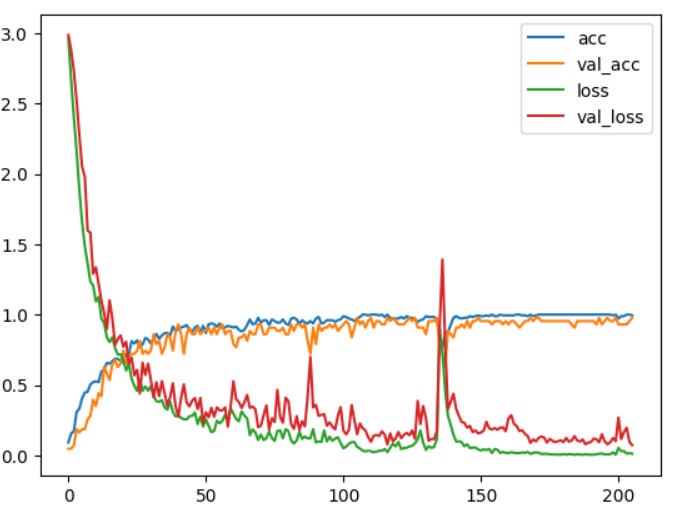

Beachten Sie, wie die Validierungsgenauigkeit schon lange stagniert, der Validierungsloss, d.h. der Wert der Verlustfunktion ausgewertet auf dem Validierungsdatensatz, seit etwa der 40. Epoche nur noch zunimmt. Der Validierungsdatensatz ist hier zu klein, um mehr sagen zu können, aber auch die Validierungsgenauigkeit scheint nach etwa der 40. Epoche abzunehmen! Es ist daher Wohl sinnvoll, dieses Modell auf diesem Datensatz nur 40 Epochen lang zu trainieren.

Dazu können Sie also nochmals das Modell erstellen, die Anzahl Epochen auf 40 setzen und Ihr finales Modell trainieren.

### Modell eine vorgegebene Anzahl Epochen lang trainieren

In [ ]:
vorgegebene_Anzahl_Epochen = 100 # Hier den Wert gemäss dem obigen Plot anpassen!
final_model = make_model() # Die bisherigen Gewichte sind damit zurückgesetzt, d.h. es wird nicht weitertrainiert, sondern nochmals ganz von vorne.
final_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

final_history = final_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=vorgegebene_Anzahl_Epochen
)

In [ ]:
plt.plot(final_history.history['accuracy'],label='acc')
plt.plot(final_history.history['val_accuracy'],label='val_acc')
plt.plot(final_history.history['loss'],label='loss')
plt.plot(final_history.history['val_loss'],label='val_loss')
plt.legend();

## Evaluation mit Validierungsdatensatz
Eine angemessene Evaluation der Güte des Modells sollte auf dem Validierungsdatensatz passieren. Der Beispiel-Datensatz ist allerdings sehr klein! Entsprechend sind hier keine besonders robusten Resultate zu erwarten. 

In [ ]:
#images = np.asarray(list(val_ds2.map(lambda x, y: x)))
y = np.asarray(list(val_ds.unbatch().map(lambda x, y: y)))
y.shape

In [ ]:
yhat = final_model.predict(val_ds)
yhatnum = yhat.argmax(axis=1)
yhatnum

In [ ]:
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=True)
plt.show()

In [ ]:
y_str = np.array(class_names)[y]
yhat_str = np.array(class_names)[yhatnum]

In [ ]:
fig,axlist = plt.subplots(1,2,figsize=(25,10));
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=True,ax=axlist[0]);axlist[0].tick_params(axis='x', rotation=45)
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=False,ax=axlist[1]);axlist[1].tick_params(axis='x', rotation=45)

# Abspeichern des Modells als Keras-Modell


In [ ]:
Keras_Dateiname = f'model_{Datensatzname}.keras'
voller_Keras_Dateiname = str(Path(model_output_path)/Keras_Dateiname)
final_model.save(voller_Keras_Dateiname)
print(f'Keras-Modell nach {voller_Keras_Dateiname} abgespeichert.')

So kann man das Modell wieder laden:

    model = tf.keras.models.load_model(voller_Keras_Dateiname)

(Es gibt aber verwirrend viele Formate- .h5, .keras, etc. Siehe auch [hier](https://www.tensorflow.org/tutorials/keras/save_and_load). Wir möchten uns an das .h5-Format halten.)  
Der folgende Befehl kann zur Vorhersage genutzt werden:

In [ ]:
loaded_model = tf.keras.models.load_model(voller_Keras_Dateiname)

In [ ]:
loaded_model.predict(val_ds)

Das wär's! Nach dem Speichern ("Save Version" in Kaggle) kann das Modell heruntergeladen werden. Vergessen Sie nicht, welche Bilder Trainingsbilder, und welche Testbilder sind. Ein Modell, das overfittet, wird auf den Trainingsdaten eine viel bessere Performanz zeigen, als auf den Testbildern. Nur jene der Testbilder darf rapportiert werden, denn nur so gut ist die Verallgemeinerungsleistung des neuronalen Netzes. Wir speichern daher noch eine Excel-Datei mit den entsprechenden Zuordnungen ab:

In [ ]:
ser = pd.Series(train_or_test)
ser

In [ ]:
ser.to_excel('train_test_split.xlsx')
ser.value_counts()

Weiter geht's mit dem Notebook [Giraffenpuzzle-Evaluation](https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-evaluation). Dort wollen wir die Performanz eines Modells evaluieren.